<Body>   
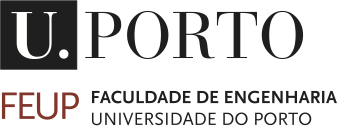   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd

## Data preprocessing

In [2]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [4]:
class FraudDataset(Dataset):
 
  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [5]:
train_dataloader = DataLoader(creditData, batch_size=32, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=32, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(16, nr_features),
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        # nn.Linear(nr_features, 32),
        # nn.ReLU(inplace = True),
        # nn.Dropout(0.2),
        
        # nn.Linear(32, 16),
        # nn.ReLU(inplace = True),
        # nn.Dropout(0.2),
        
        # nn.Linear(16, 1),
        
        # )
        nn.Linear(nr_features, 256),
        # nn.ReLU(),
        # nn.Linear(1024, 512),
        # nn.ReLU(),
        # nn.Dropout(0.2),
        
        # nn.Linear(512, 256),
        # nn.ReLU(),
        # nn.Dropout(0.2),
        
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(16, 1),
            
        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

####  Loss Function + Device + Reset Gradients Funct.

In [8]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 1
        self.clip_value = 0.01
        self.cur_batch_size = 64
        self.latent_dim = 128
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(self.device)
        self.D = Discriminator(nr_features=self.dataset.features).to(self.device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)

        



    def train_generator(self,real_data):
        # Clear generator gradients
        self.g_optimizer.zero_grad()

        fake_targets = torch.ones(real_data.size(0)).to(self.device)
        fake_targets = fake_targets - 0.1

        # Random noise from a uniform distribution
        latent_space_samples = torch.randn(real_data.size(0), self.latent_dim).to(self.device)
        generated_data = self.G(latent_space_samples)  # Fake data generated by the generator
        fake_preds = self.D(generated_data).reshape(-1)

        g_loss = self.criterion(fake_preds, fake_targets)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, generated_data

    def train_discriminator(self, real_data, real_labels):
    # Reset gradients
        
        self.d_optimizer.zero_grad()
        real_labels = torch.ones(real_data.size(0)).to(self.device) * 0.9
        
        real_preds = self.D(real_data).reshape(-1)
        d_loss_real = self.criterion(real_preds, real_labels)
        
        fake_labels = torch.zeros(self.cur_batch_size).to(self.device) * 0.1

        # random noise from uniform distribution
        latent_space_samples = torch.randn(self.cur_batch_size, self.latent_dim).to(self.device)

   
        generated_data = self.G(latent_space_samples).detach()  # fake data generated by generator
        fake_preds = self.D(generated_data).reshape(-1)
        d_loss_fake = self.criterion(fake_preds, fake_labels)
        #d_loss_fake = self.criterion(fake_preds, fake_labels)
        
        loss = d_loss_real + d_loss_fake

        # Compute gradients
        loss.backward()
        # Adjust the parameters using backprop
        self.d_optimizer.step()
        
            
        return loss

    def train(self,real_data, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(epochs):  
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                # Train discriminator
                d_error = self.train_discriminator(real_data, real_labels)
                #Clip weights of discriminator
                # for p in self.D.parameters():
                #     p.data.clamp_(-self.clip_value, self.clip_value)
                #Clip weights of generator
                # for p in self.G.parameters():
                #     p.data.clamp_(-self.clip_value, self.clip_value)


                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = self.train_generator(real_data)        
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch, epoch, i+1, len(self.dataloader), d_error.item(), g_error.item()))
            
        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(self.device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [9]:
gan = GAN(df_train)

In [10]:
losses_gen, losses_dis = gan.train(df_train, epochs=400)

Epoch [0/0], Step [25/25], d_loss: 34.6722, g_loss: 0.7239 

Epoch [1/1], Step [25/25], d_loss: 10.6684, g_loss: 0.7161 

Epoch [2/2], Step [25/25], d_loss: 10.6612, g_loss: 0.7211 

Epoch [3/3], Step [25/25], d_loss: 10.6577, g_loss: 0.7283 

Epoch [4/4], Step [25/25], d_loss: 10.6550, g_loss: 0.7269 

Epoch [5/5], Step [25/25], d_loss: 13.9112, g_loss: 0.7342 

Epoch [6/6], Step [25/25], d_loss: 10.4760, g_loss: 0.7327 

Epoch [7/7], Step [25/25], d_loss: 17.2204, g_loss: 0.7388 

Epoch [8/8], Step [25/25], d_loss: 10.6317, g_loss: 0.7410 

Epoch [9/9], Step [25/25], d_loss: 10.6221, g_loss: 0.7526 

Epoch [10/10], Step [25/25], d_loss: 10.6118, g_loss: 0.7579 

Epoch [11/11], Step [25/25], d_loss: 10.6061, g_loss: 0.7546 

Epoch [12/12], Step [25/25], d_loss: 10.5979, g_loss: 0.7947 

Epoch [13/13], Step [25/25], d_loss: 10.5855, g_loss: 0.7854 

Epoch [14/14], Step [25/25], d_loss: 10.5644, g_loss: 0.7915 

Epoch [15/15], Step [25/25], d_loss: 10.5412, g_loss: 0.8214 

Epoch [16/16

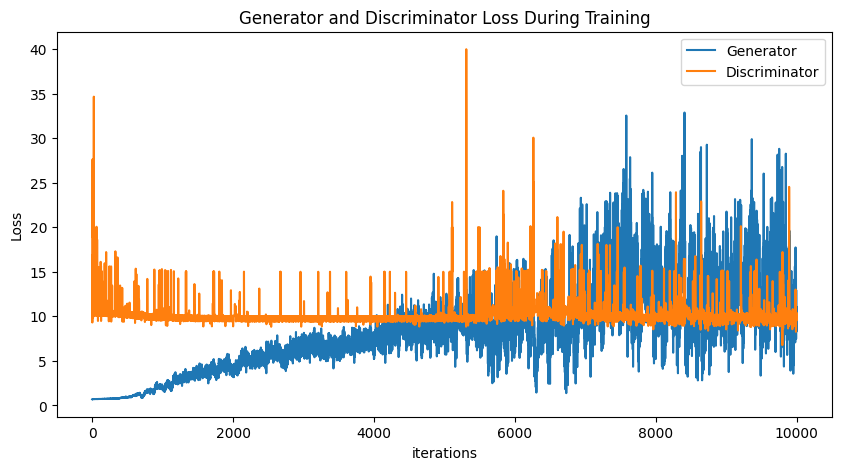

In [11]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [12]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

In [13]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
165061,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
238186,149565.0,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
150562,93670.0,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
138452,82655.0,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


In [14]:
df_concat['Class'].value_counts()

Class
1.0    227845
0.0    227451
Name: count, dtype: int64

### Model evaluation

In [15]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [16]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        print(classification_report(test_df['Class'].values, labels))

In [17]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=100)
fw_model.evaluate(df_test, confidence=0.90)

KeyboardInterrupt: 